<a href="https://colab.research.google.com/github/JPeal-FUS/MTH-315-A-2025_FUS/blob/main/Peal%2C_James_DS_A04_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 04 (INDIVIDUAL) — Regression on Pet Anxiety Dataset (25 ⭕️s)
_Course:_ Intro to Data Science · _Runtime:_ Python 3 · _Kernel:_ IPykernel

_Points guide:_ ⭕️ = 1 point · Total = 25 ⭕️

James Peal

## Overview


You will examine a synthetic dataset from a **vet clinic**. You will find models to predict the anxiety experience by pets visiting the clinic and then you will make recommendations based on what you learn from fitting those models.

**What you’ll practice in this notebook**

1. Fit and interpret **Linear and/or Polynomial Regression**
2. Evaluate the ML models you fit with **R²**, residuals, and visualization of actual vs predicted values
3. Evaluate fits and make recommendations based on your results.


## Task 1 — Load, Inspect & Summarize


- Load `vet_anxiety.csv` into a DataFrame `df`
- Show `.head()`, `.info()`, and basic `.describe()`; compute `.nunique()` for categoricals
- Create a quick correlation heatmap of numeric variables (use `seaborn.heatmap`)  


,Pet_ID,Visit_ID,Pet_Name,Species,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Invasive_Treatment,Anxiety
0,P0001,V000001,Nano,Dog,7,12.60,10.0,15,16,10.0,1,False,4.0
1,P0002,V000002,Leo,Dog,3,25.41,5.7,52,8,7.0,1,False,3.0
2,P0003,V000003,Rosie,Cat,7,4.92,5.9,60,26,5.0,0,True,10.0
3,P0004,V000004,Teddy,Cat,14,6.12,5.1,10,19,4.0,3,True,6.0
4,P0005,V000005,Finn,Dog,4,27.24,4.0,5,28,7.5,1,False,3.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pet_ID              350 non-null    object 
 1   Visit_ID            350 non-null    object 
 2   Pet_Name            350 non-null    object 
 3   Species             350 non-null    object 
 4   Age_Years           350 non-null    int64  
 5   Pet_Weight_kg       350 non-null    float64
 6   Health_Score        350 non-null    float64
 7   Visit_Length        350 non-null    int64  
 8   Wait_Time           350 non-null    int64  
 9   Owner_Calmness      350 non-null    float64
 10  Treats_Given        350 non-null    int64  
 11  Invasive_Treatment  350 non-null    bool   
 12  Anxiety             350 non-null    float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 33.3+ KB
None


,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Anxiety
count,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00
mean,6.25,15.67,5.83,32.95,15.52,6.02,1.58,4.43
std,3.00,10.93,1.88,15.64,8.75,1.73,0.86,2.31
min,1.00,0.31,0.20,5.00,0.00,0.00,0.00,0.00
25%,4.00,4.83,4.50,19.25,8.00,5.00,1.00,3.00
50%,6.00,15.83,5.90,33.00,16.00,6.00,2.00,4.00
75%,8.00,24.27,7.10,47.00,23.00,7.00,2.00,6.00
max,14.00,44.41,10.00,60.00,30.00,10.00,3.00,10.00


,0
Pet_ID,350
Visit_ID,350
Pet_Name,41
Species,4


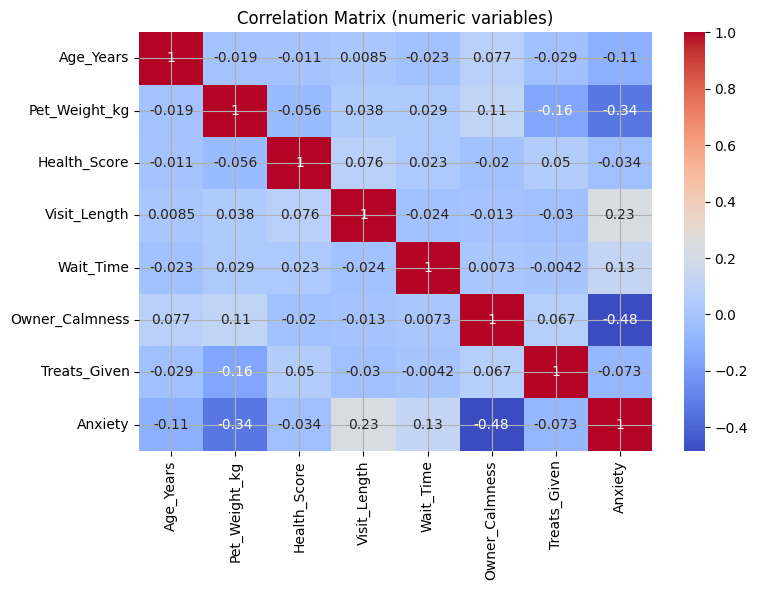

In [ ]:

import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7.5,4.5)
plt.rcParams["axes.grid"] = True

df = pd.read_csv("pets_vet_anxiety_dataset.csv")

display(df.head())
print(df.info())
display(df.select_dtypes(include=[np.number]).describe().round(2))
display(df.select_dtypes(include=['object']).nunique())

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric variables)")
plt.tight_layout()
plt.show()


## Task 2 — Linear Regression

- Split data into train/test (80/20) to predict `Anxiety` from sensible predictors  
- Fit a `LinearRegression` model in a `Pipeline` with `StandardScaler`  
- Report **R²** on train and test; list the top 5 absolute coefficients (by magnitude)  


In [ ]:

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target = "Anxiety"

# Let's turn Species into a numerical value to see it in the table
df_model = pd.get_dummies(df.copy(), columns=["Species"], drop_first=True)
features = [c for c in df_model.columns if c not in ["Pet_ID","Visit_ID","Pet_Name", target]]
X = df_model[features].astype(float)
y = df_model[target].astype(float)

# Split dataset into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# This pipeline will run the items contained in order
# Standard Scaler applies a normalization
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_lr.fit(X_train, y_train)
pred_tr = pipe_lr.predict(X_train)
pred_te = pipe_lr.predict(X_test)

r2_tr = r2_score(y_train, pred_tr)
r2_te = r2_score(y_test, pred_te)

print(f"Linear Regression —  R² (train): {r2_tr:.3f}")
print(f"Linear Regression —  R² (test):  {r2_te:.3f}")

# You can print the coefficients (w) to see how much each coefficient matters to the fit
coefs = pipe_lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': coefs, 'abs_coef': np.abs(coefs)}).sort_values('abs_coef', ascending=False)
display(coef_df.head(10))


Linear Regression —  R² (train): 0.477
Linear Regression —  R² (test):  0.415


,feature,coef,abs_coef
8,Species_Cat,1.113136,1.113136
5,Owner_Calmness,-1.014155,1.014155
10,Species_Rabbit,0.458095,0.458095
9,Species_Dog,0.430779,0.430779
3,Visit_Length,0.410382,0.410382
4,Wait_Time,0.289330,0.289330
7,Invasive_Treatment,0.277842,0.277842
6,Treats_Given,-0.222979,0.222979
2,Health_Score,-0.176237,0.176237
0,Age_Years,-0.165207,0.165207


## Q1 - Is the linear regression model from task 2 a good fit? (1+3 ⭕️s)

⭕️



Extra Credit - How do you know if it is a good fit? List 2 reasons for why or why not.

⭕️⭕️⭕️

It is an ok fit but not great since the R^2 value fell in between the 0.4-0.5 mark in training and testing. This means that over half of the variance in the data was not explained through this linear regression. Another factor that supports this is if you compare the correlation coefficients found through the linear regression, there is a decent difference between them and the actual correlations found in the heatmap.

## Task 3 — Fit a regression model to predict Cat anxiety





First, let's inspect the dataset to decide what variables to use:
- Visualize the correlation matrix for Cats only (make it civilized and with values printed on each item)

- Visualize the pairplot for cats only. Pick a reasonable variable for hue

,Pet_ID,Visit_ID,Pet_Name,Species,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Invasive_Treatment,Anxiety
2,P0003,V000003,Rosie,Cat,7,4.92,5.9,60,26,5.0,0,True,10.0
3,P0004,V000004,Teddy,Cat,14,6.12,5.1,10,19,4.0,3,True,6.0
6,P0007,V000007,Chloe,Cat,2,4.99,8.9,38,12,5.0,2,False,4.0
7,P0008,V000008,Ollie,Cat,7,6.27,7.5,18,8,3.5,3,False,2.5
13,P0014,V000014,Luna,Cat,7,3.91,6.8,31,0,6.0,2,True,3.0


<class 'pandas.core.frame.DataFrame'>
Index: 110 entries, 2 to 347
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pet_ID              110 non-null    object 
 1   Visit_ID            110 non-null    object 
 2   Pet_Name            110 non-null    object 
 3   Species             110 non-null    object 
 4   Age_Years           110 non-null    int64  
 5   Pet_Weight_kg       110 non-null    float64
 6   Health_Score        110 non-null    float64
 7   Visit_Length        110 non-null    int64  
 8   Wait_Time           110 non-null    int64  
 9   Owner_Calmness      110 non-null    float64
 10  Treats_Given        110 non-null    int64  
 11  Invasive_Treatment  110 non-null    bool   
 12  Anxiety             110 non-null    float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 11.3+ KB
None


,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Anxiety
count,110.00,110.00,110.00,110.00,110.00,110.00,110.00,110.00
mean,6.20,4.38,6.03,34.44,15.29,5.66,1.68,5.75
std,3.09,0.94,1.74,15.06,8.90,1.65,0.87,2.27
min,1.00,2.34,1.10,6.00,0.00,0.00,0.00,0.00
25%,4.00,3.74,5.10,22.00,8.00,5.00,1.00,4.50
50%,6.00,4.38,6.05,35.00,16.00,5.50,2.00,5.50
75%,8.00,5.03,7.20,45.75,23.00,7.00,2.00,7.50
max,14.00,6.55,9.60,60.00,30.00,9.00,3.00,10.00


,0
Pet_ID,110
Visit_ID,110
Pet_Name,39
Species,1


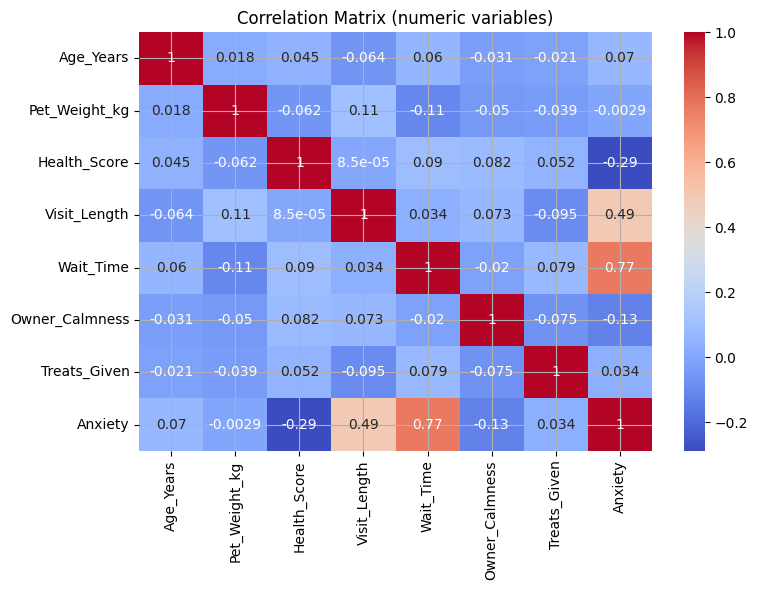

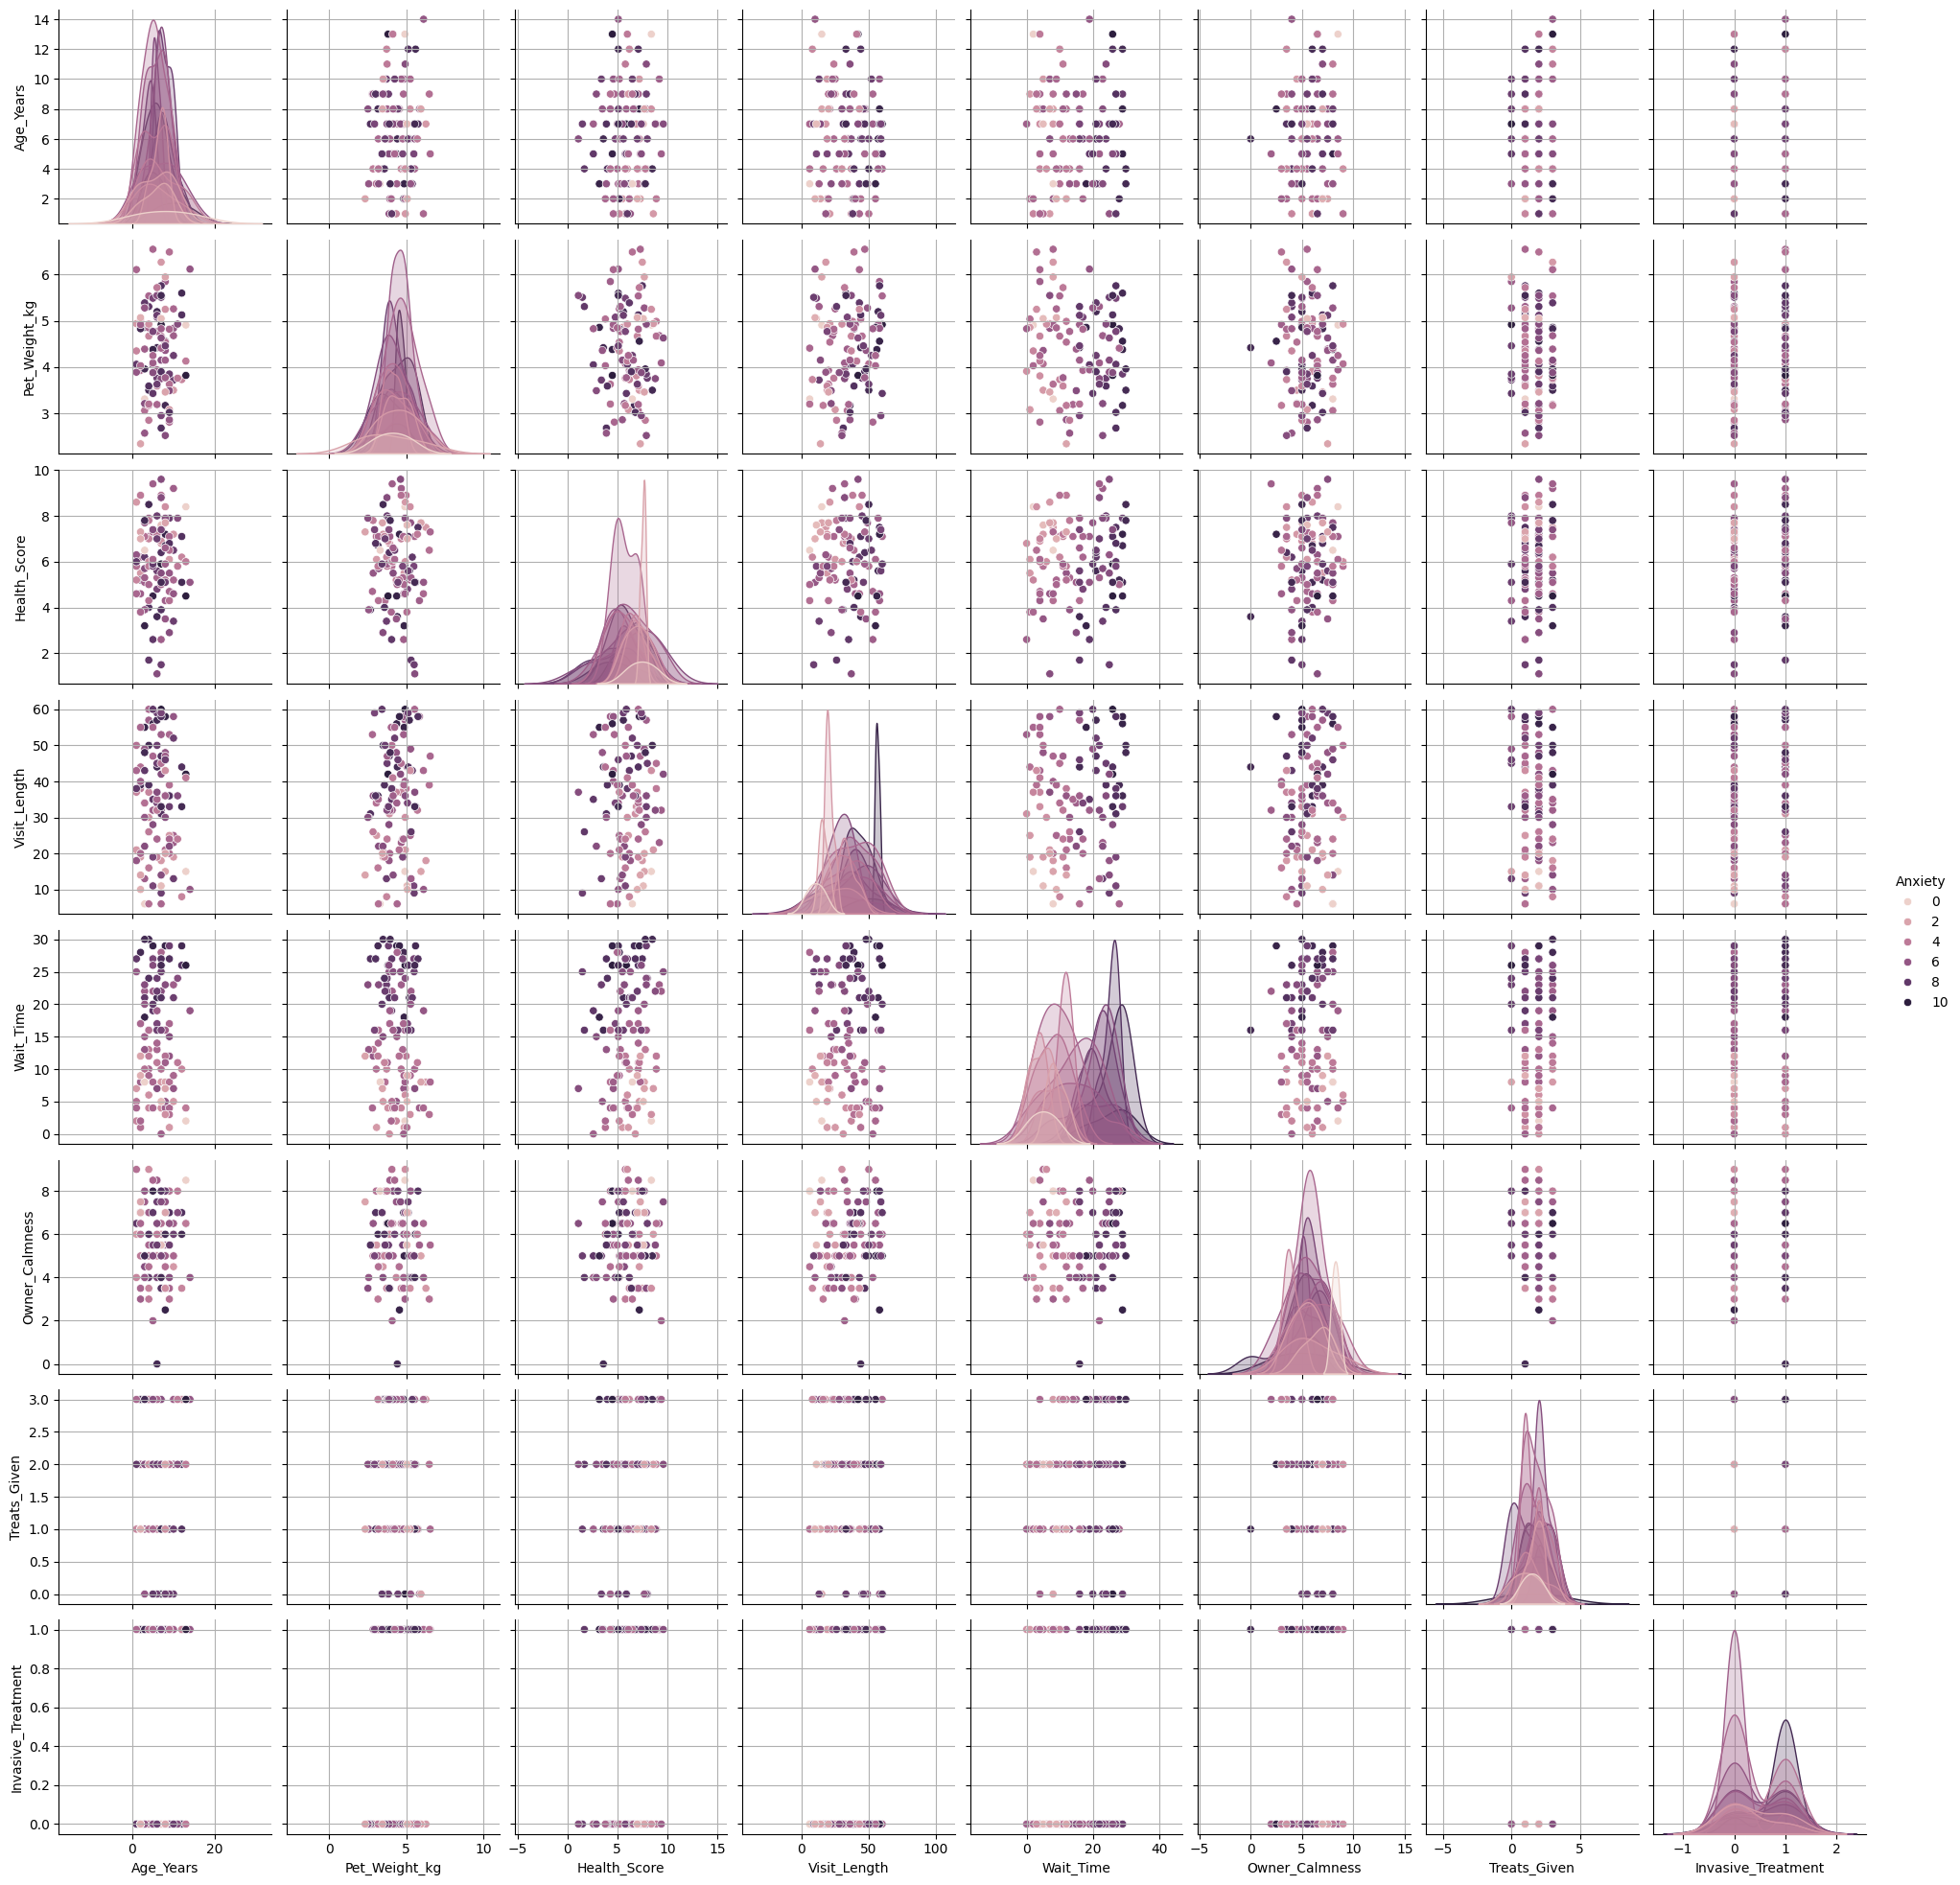

In [ ]:

import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7.5,4.5)
plt.rcParams["axes.grid"] = True

df = pd.read_csv("pets_vet_anxiety_dataset.csv")

df = df[df["Species"] == "Cat"]

display(df.head())
print(df.info())
display(df.select_dtypes(include=[np.number]).describe().round(2))
display(df.select_dtypes(include=['object']).nunique())

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric variables)")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue='Anxiety')
plt.show()


## Task 3 Questions (4 ⭕️s)



### Visualizations (2 plots above)

⭕️


### Q2 - What did you learn from each of the visualizations above?

⭕️



It appears that for cats, wait time and visit length seem to be the highest causers of anxiety. Wait time is especially correlated to anxiety with a correlation of 0.77. It is also apparent that health score seems to be negatively correlated to anxiety to an extent, suggesting that the better the health score of a cat, the lower the anxiety.

### Q3 - What variable(s) will you be using for your fit?

⭕️

I will be using wait time vs anxiety for my fit.

### Q4 - What model will you be fitting? (Linear/Polynomial)

⭕️

Linear

## Fit your model for task 3 (5 ⭕️s)
- Remember to split 80/20 and scale the values



### Produce metrics to evaluate your model

- Visualize the residuals, plot $y$ vs $\hat y$, and print the value of $R^2$ for your fit.

⭕️⭕️⭕️

**Your model must have $R^2$ > 0.8 to get any points for this section**

- Print the coefficients ($w_i$) for each feature used (include engineered if your model used any)  

⭕️⭕️

In [ ]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

target = "Anxiety"

df = pd.read_csv("pets_vet_anxiety_dataset.csv")

df_cats = df[df["Species"] == "Cat"]

# Let's turn Species into a numerical value to see it in the table
df_model = pd.get_dummies(df_cats.copy(), columns=["Species"], drop_first=True)
features = [c for c in df_model.columns if c not in ["Pet_ID","Visit_ID","Pet_Name", target]]
X = df_model[features].astype(float)
y = df_model[target].astype(float)

# Split dataset into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# This pipeline will run the items contained in order
# Standard Scaler applies a normalization
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_lr.fit(X_train, y_train)
pred_tr = pipe_lr.predict(X_train)
pred_te = pipe_lr.predict(X_test)

r2_tr = r2_score(y_train, pred_tr)
r2_te = r2_score(y_test, pred_te)

print(f"Linear Regression —  R² (train): {r2_tr:.3f}")
print(f"Linear Regression —  R² (test):  {r2_te:.3f}")

# You can print the coefficients (w) to see how much each coefficient matters to the fit
coefs = pipe_lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': coefs, 'abs_coef': np.abs(coefs)}).sort_values('abs_coef', ascending=False)
display(coef_df.head(10))

Linear Regression —  R² (train): 0.988
Linear Regression —  R² (test):  0.941


,feature,coef,abs_coef
4,Wait_Time,1.682910,1.682910
3,Visit_Length,0.997431,0.997431
2,Health_Score,-0.797076,0.797076
7,Invasive_Treatment,0.380753,0.380753
5,Owner_Calmness,-0.290117,0.290117
0,Age_Years,0.085888,0.085888
6,Treats_Given,0.037178,0.037178
1,Pet_Weight_kg,-0.032105,0.032105


## Task 4 — Fit a regression model to predict Dog anxiety



First, let's inspect the dataset to decide what variables to use:
- Visualize the correlation matrix for Dogs only (make it civilized and with values printed on each item)

- Visualize the pairplot for dogs only. Pick a reasonable variable for hue


,Pet_ID,Visit_ID,Pet_Name,Species,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Invasive_Treatment,Anxiety
0,P0001,V000001,Nano,Dog,7,12.60,10.0,15,16,10.0,1,False,4.0
1,P0002,V000002,Leo,Dog,3,25.41,5.7,52,8,7.0,1,False,3.0
4,P0005,V000005,Finn,Dog,4,27.24,4.0,5,28,7.5,1,False,3.5
8,P0009,V000009,Frankie,Dog,11,21.02,6.1,49,13,4.5,2,True,3.5
9,P0010,V000010,Millie,Dog,8,14.07,4.7,58,24,7.0,1,False,3.0


<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, 0 to 349
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pet_ID              223 non-null    object 
 1   Visit_ID            223 non-null    object 
 2   Pet_Name            223 non-null    object 
 3   Species             223 non-null    object 
 4   Age_Years           223 non-null    int64  
 5   Pet_Weight_kg       223 non-null    float64
 6   Health_Score        223 non-null    float64
 7   Visit_Length        223 non-null    int64  
 8   Wait_Time           223 non-null    int64  
 9   Owner_Calmness      223 non-null    float64
 10  Treats_Given        223 non-null    int64  
 11  Invasive_Treatment  223 non-null    bool   
 12  Anxiety             223 non-null    float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 22.9+ KB
None


,Age_Years,Pet_Weight_kg,Health_Score,Visit_Length,Wait_Time,Owner_Calmness,Treats_Given,Anxiety
count,223.00,223.00,223.00,223.00,223.00,223.00,223.00,223.00
mean,6.25,22.32,5.76,32.53,15.51,6.16,1.52,3.71
std,2.94,8.03,1.96,15.70,8.71,1.76,0.87,1.89
min,1.00,2.16,0.20,5.00,0.00,1.00,0.00,0.00
25%,4.00,16.73,4.50,18.00,8.00,5.00,1.00,2.50
50%,6.00,21.77,5.80,32.00,16.00,6.50,1.00,3.50
75%,8.00,28.01,7.10,48.00,23.00,7.50,2.00,5.00
max,14.00,44.41,10.00,60.00,30.00,10.00,3.00,10.00


,0
Pet_ID,223
Visit_ID,223
Pet_Name,41
Species,1


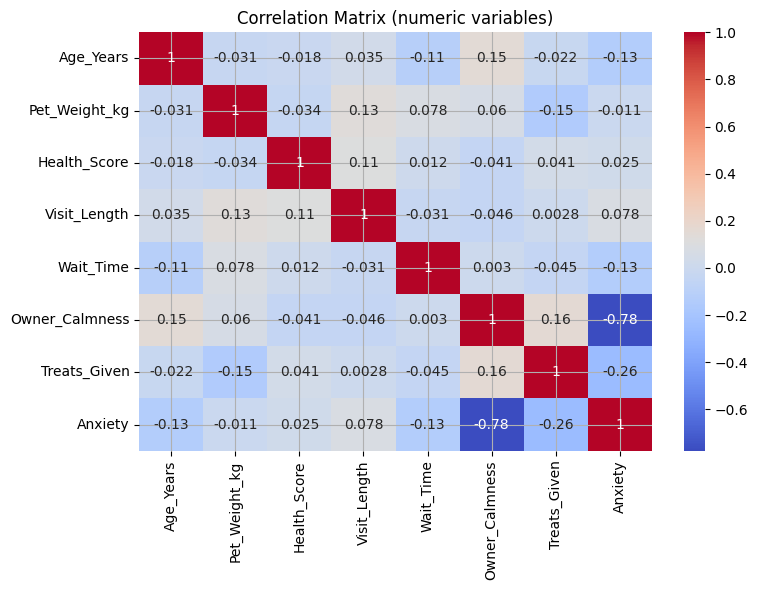

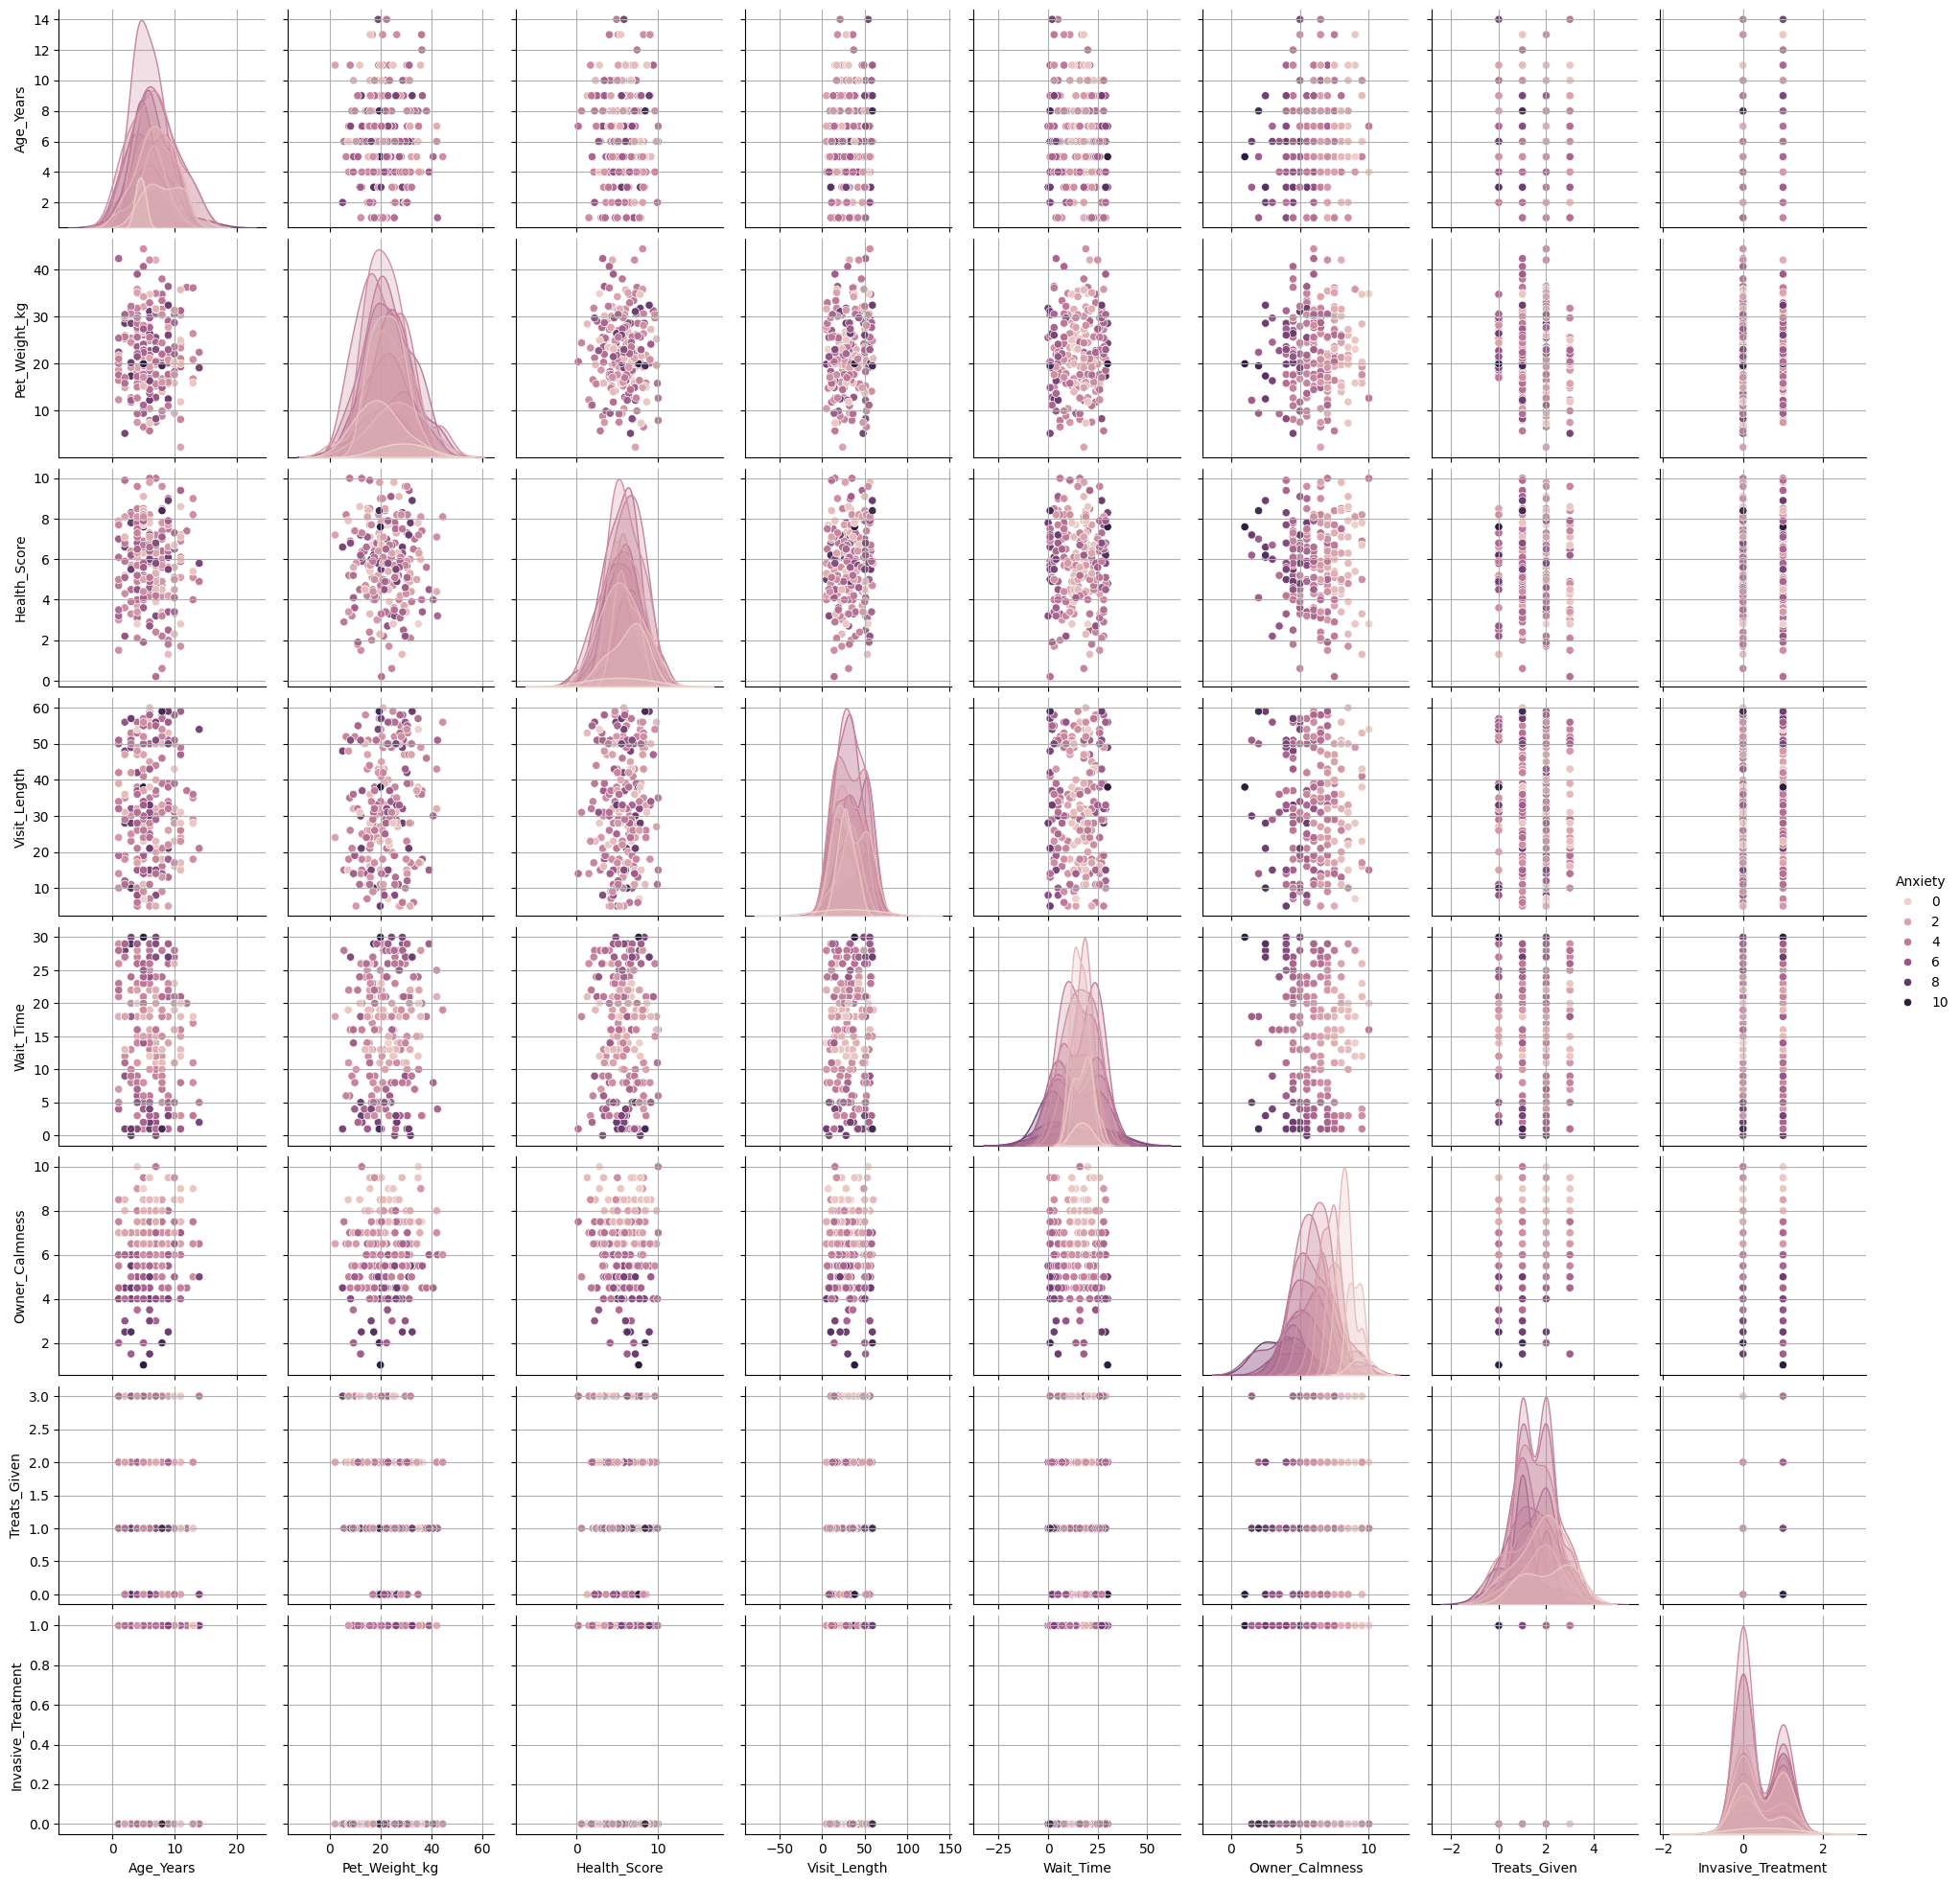

In [ ]:

import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7.5,4.5)
plt.rcParams["axes.grid"] = True

df = pd.read_csv("pets_vet_anxiety_dataset.csv")

df = df[df["Species"] == "Dog"]

display(df.head())
print(df.info())
display(df.select_dtypes(include=[np.number]).describe().round(2))
display(df.select_dtypes(include=['object']).nunique())

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric variables)")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue='Anxiety')
plt.show()

## Task 4 Questions (4 ⭕️s)



### Visualizations (2 plots above)

⭕️


### Q5 - What did you learn from each of the visualizations above?

⭕️



It appears that for dogs, owner calmness seem to be the highest correlation with anxiety with -0.78. There also seems to be a slight corralation to treats given with -0.26.

### Q6 - What variable(s) will you be using for your fit?

⭕️

I will be using owner calmness vs anxiety for my fit.

### Q7 - What model will you be fitting? (Linear/Polynomial)

⭕️

Polynomial




## Fit your model for task 4 (5 ⭕️s)
- Remember to split 80/20 and scale the values

### Produce metrics to evaluate your model

- Visualize the residuals, plot $y$ vs $\hat y$, and print the value of $R^2$ for your fit.

⭕️⭕️⭕️

**Your model must have $R^2$ > 0.8 to get any points for this section**

- Print the coefficients ($w_i$) for each feature used (include engineered if your model used any)  

⭕️⭕️

In [ ]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

target = "Anxiety"

df = pd.read_csv("pets_vet_anxiety_dataset.csv")

df_dogs = df[df["Species"] == "Dog"]

# Let's turn Species into a numerical value to see it in the table
df_model = pd.get_dummies(df_dogs.copy(), columns=["Species"], drop_first=True)
features = [c for c in df_model.columns if c not in ["Pet_ID","Visit_ID","Pet_Name", target]]
X = df_model[features].astype(float)
y = df_model[target].astype(float)

# Split dataset into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# This pipeline will run the items contained in order
# Standard Scaler applies a normalization
pipe_poly = Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_poly.fit(X_train, y_train)
pred_tr = pipe_poly.predict(X_train)
pred_te = pipe_poly.predict(X_test)

r2_tr = r2_score(y_train, pred_tr)
r2_te = r2_score(y_test, pred_te)

print(f"Ploynomial Regression —  R² (train): {r2_tr:.3f}")
print(f"Polynomial Regression —  R² (test):  {r2_te:.3f}")

# You can print the coefficients (w) to see how much each coefficient matters to the fit
coefs = pipe_lr.named_steps['lr'].coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': coefs, 'abs_coef': np.abs(coefs)}).sort_values('abs_coef', ascending=False)
display(coef_df.head(10))

Ploynomial Regression —  R² (train): 0.979
Polynomial Regression —  R² (test):  0.967


,feature,coef,abs_coef
5,Owner_Calmness,-1.349426,1.349426
6,Treats_Given,-0.250370,0.250370
4,Wait_Time,-0.214746,0.214746
3,Visit_Length,0.089598,0.089598
7,Invasive_Treatment,0.086625,0.086625
0,Age_Years,-0.063819,0.063819
1,Pet_Weight_kg,0.040961,0.040961
2,Health_Score,-0.005091,0.005091


## Recommendations (6 ⭕️s)



### Q8 - What would you recommend for Cat owners to reduce their pet's anxiety at the vet?
Quantify your recommendation (Example: how much do you expect it to improve? Any **correct** quantitative metric to motivate your recommendation is OK)

⭕️⭕️




I would reccomend that they leave rather close to the appointment time in order to reduce wait time, as well as making sure to notify the vet as soon as they are there in order to minimize the time before being seen. For every 1-minute less waiting for the cat, there is a decrease of 1.683 in the cat's  on a 10-point scale.

### Q9 - What would you recommend for Dog owners to reduce their pet's anxiety at the vet?

Quantify your recommendation (Example: how much do you expect it to improve? Any **correct** quantitative metric to motivate your recommendation is OK)

⭕️⭕️


I would reccomend that the oweners maintain a very calm demenor while taking their pet to the vet. Every one point increase on a 10-point scale of owner calmness would result in a 1.349426 point decrease in anxiety on a 10-point scale.




### Q10 - What can the vet do to reduce the anxiety of the pets that they serve?

Quantify your recommendation (Example: how much do you expect it to improve? Any **correct** quantitative metric to motivate your recommendation is OK)

⭕️⭕️

I would reccomend that vets work to decrease the length of the visits as much as possible. For every minute less that the visits last, the pets will have about 0.410382 points less anxiety on a 10-point scale.